# Noiseless data
In many machine learning applications for engineering simulations, data can be inherently noise-free. This often occurs when the data is generated by deterministic processes, such as simulators or mathematical models, where the only sources of variation are minor, stemming from numerical integration errors or floating-point precision limitations. In such cases, the standard Gaussian process (GP) models, which typically assume the presence of noise in the data, may incorrectly attribute meaningful patterns or signals to noise. This misinterpretation can reduce the model's ability to accurately capture the underlying data structure and limit its expressivity.

To address this, we use zero-noise Gaussian processes. These models are specifically designed to handle noise-free data by assuming that any apparent noise in the observations is not inherent to the data-generating process, but rather, due to external factors. By setting the noise variance to zero or a very small value, zero-noise GPs allow us to maintain the fidelity of the observed data, ensuring that the model does not unnecessarily smooth over important features.

In this Jupyter Notebook you will:
1. [Generate a noise free dataset.](#1.-Generate-a-noise-free-dataset)
2. [Train a `zero_noise_gp` and plot the predictions.](#2.-Train-a-zero_noise_gp-and-plot-the-predictions)
3. [Comparing to noisy data.](#3.-Comparing-to-noisy-data.)
4. [Delete datasets and trained emulators.](#4.-Delete-datasets-and-trained-emulators)

Start by importing the packages required for this tutorial.

In [1]:
# Third party imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# twinLab import
import twinlab as tl

# Set seed for reproducibility
np.random.seed(17)


          ====== TwinLab Client Initialisation ======
          Version     : 2.12.0
          User        : jamie@digilab.co.uk
          Server      : https://twinlab.digilab.co.uk/v3
          Environment : /Users/jamiedonald-mccann/Desktop/twinLab/tutorials/.env



Make sure you set up your API key and other information to be able to use `twinLab`, either through a `.env` file, using `secrets`, or through `tl.set_user`/`tl.set_api_key`. 

### **1. Generate a noise free dataset**
In this step, a dataset is created using a scaled oscillator function that produces precise outputs without any inherent randomness. This data will serve as the "true" representation of the underlying process, unaffected by noise or uncertainty, providing a clean benchmark for training and evaluation.

In [2]:
# The true function
def oscillator(x):
    return np.cos((x - 5) / 2) ** 2 * x * 2


# Generate true data
X = np.linspace(-15, 15, 100)[:, np.newaxis]
y = oscillator(X)

# Generate train data
n_data = 15  # Number of data points
X_data = np.random.uniform(-10, 10, size=n_data)
y_data = oscillator(X_data)

Now you can plot the data points to visualize the noise free data.

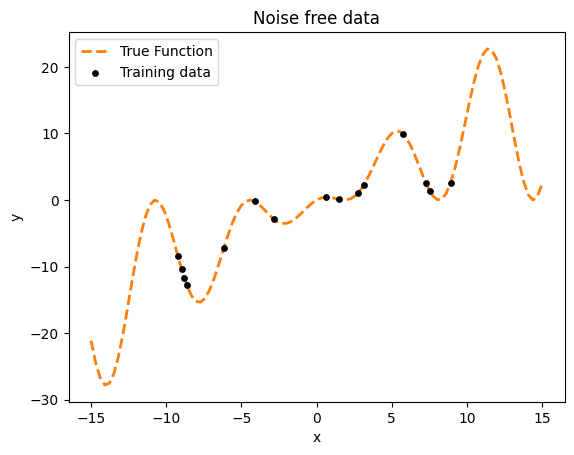

In [3]:
# Plot the true function
plt.plot(
    X,
    y,
    linewidth=2,
    label="True Function",
    color="tab:orange",
    linestyle="dashed",
    zorder=1,
)
# Plot the training data points
plt.scatter(X_data, y_data, label="Training data", color="k", s=15, zorder=2)

plt.xlabel("x")
plt.ylabel("y")
plt.title("Noise free data")
plt.legend()
plt.show()

The data can now be converted to a `pandas` DataFrame ready for training.

In [4]:
# Convert to dataframe
df = pd.DataFrame({"X": X_data, "y": y_data})

# Upload the dataset to twinLab
dataset = tl.Dataset(id="zero_noise")
dataset.upload(df)

### **2. Train a `zero_noise_gp` and plot the predictions**
Using the noise-free data generated in the previous step, you can train a zero noise Gaussian process emulator by defining the `estimator_type` as `zero_noise_gp` in the `tl.EstimatorParams`. 
The zero noise GP is configured to assume minimal or no observation noise, allowing it to focus entirely on capturing the underlying signal in the data. This helps in preserving the exact relationships and patterns present in the training set.

In [5]:
# Train a zero-noise emulator
emulator = tl.Emulator(id="emulator_zero_noise")

# Set up your estimator and training parameters
estimator_params = tl.EstimatorParams(
    estimator_type="zero_noise_gp"
)  # Define the estimator_type as zero_noise_gp
train_params = tl.TrainParams(
    estimator_params=estimator_params
)  # Define the train_params to use estimator_params

# Train the emulator
emulator.train(dataset, inputs=["X"], outputs=["y"], params=train_params)

Emulator 'emulator_zero_noise' has begun training.
0:00:00: Job status: processing
0:00:01: Job status: success
Training of emulator emulator_zero_noise is complete!


You can now plot the mean predictions and the standard deviation on the predictions of the trained emulator using `Emulator.plot` function in `twinLab`.


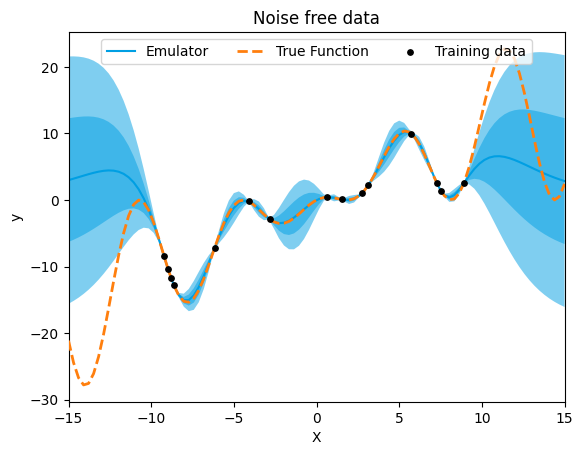

In [6]:
# Plot mean predictions and the standard deviation on the predictions
plt = emulator.plot(x_axis="X", y_axis="y", x_lim=(-15, 15))
# Plot the ground truth function
plt.plot(
    X,
    y,
    linewidth=2,
    label="True Function",
    color="tab:orange",
    linestyle="dashed",
    zorder=10,
)
# Plot the training data
plt.scatter(X_data, y_data, label="Training data", color="k", s=15, zorder=11)
plt.legend(ncol=3, loc="upper center").set_zorder(12)
plt.title("Noise free data")
plt.show()

You can see from the plotted predictions above that the uncertainty around the data points is very low and rises where there is a lack of data points. Hence, for a true function where the data points can be assumed to be precise the `twinLab` `zero_noise_gp` produces very accurate predictions, despite there not being many data points for the emulator to train on.

### **3. Comparing to noisy data**
To evaluate the behaviour of the `zero_noise_gp` in the presence of noise, you can generate a new dataset by adding random noise to the previously generated noise-free data. This noise can mimic real-world measurement errors or other uncertainties. This will allow you to observe how the `zero_noise_gp` performs when faced with noisy training data.

First, set a noise scale and generate the noisy dataframe.

In [7]:
# Set noise scale
noise_scale = 0.7

# Add noise to data
y_noisy = y_data + np.random.normal(scale=noise_scale, size=X_data.shape)

# Convert to dataframe
noisy_df = pd.DataFrame({"X": X_data, "y": y_noisy})

# Upload the dataset to twinLab
noisy_dataset = tl.Dataset(id="with_noise")
noisy_dataset.upload(noisy_df)

Now you can plot the data points to visualize noisy data. You should be able to see that the data points no longer fit the true function curve as precisely as before.

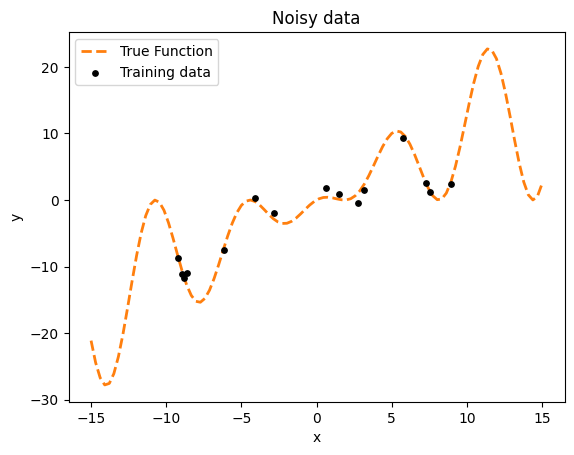

In [8]:
# Plot the true function
plt.plot(
    X,
    y,
    linewidth=2,
    label="True Function",
    color="tab:orange",
    linestyle="dashed",
    zorder=1,
)
# Plot the training data
plt.scatter(X_data, y_noisy, label="Training data", color="k", s=15, zorder=2)

plt.xlabel("x")
plt.ylabel("y")
plt.title("Noisy data")
plt.legend()
plt.show()

Train the `zero_noise_gp` using `emulator.train` and plot the predictions using `emulator.plot`.

In [9]:
# Train a zero-noise emulator
emulator = tl.Emulator(id="emulator_with_noise")

# Set up your estimator and training parameters
estimator_params = tl.EstimatorParams(estimator_type="zero_noise_gp")
train_params = tl.TrainParams(estimator_params=estimator_params)

# Train the emulator
emulator.train(noisy_dataset, inputs=["X"], outputs=["y"], params=train_params)

Emulator 'emulator_with_noise' has begun training.
0:00:00: Job status: processing
0:00:01: Job status: success
Training of emulator emulator_with_noise is complete!


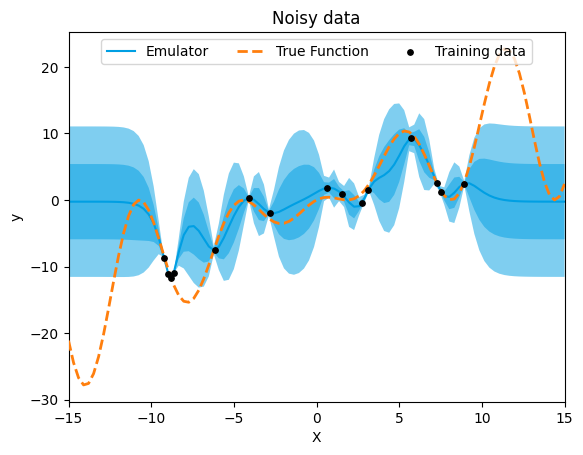

In [10]:
# Plot mean predictions and the standard deviation on the predictions
plt = emulator.plot(x_axis="X", y_axis="y", x_lim=(-15, 15))
# Plot the ground truth function
plt.plot(
    X,
    y,
    linewidth=2,
    label="True Function",
    color="tab:orange",
    linestyle="dashed",
    zorder=10,
)
# Plot the training data
plt.scatter(X_data, y_noisy, label="Training data", color="k", s=15, zorder=11)
plt.legend(ncol=3, loc="upper center").set_zorder(12)
plt.title("Noisy data")
plt.show()

The `zero_noise_gp` produces strange results when there is some (even a small amount of) noise in the dataset because it inherently assumes that the data is perfectly accurate and free from noise. This assumption leads to large amounts of uncertainty between observed data points, especially when using a sparse amount of training data like in this example, as the emulator struggles to understand the underlying behaviour of the true function.

When dealing with noise in your dataset it is more applicable to use a `single_task_gp`.

Emulator 'emulator_single_task' has begun training.
0:00:00: Job status: processing
0:00:02: Job status: success
Training of emulator emulator_single_task is complete!


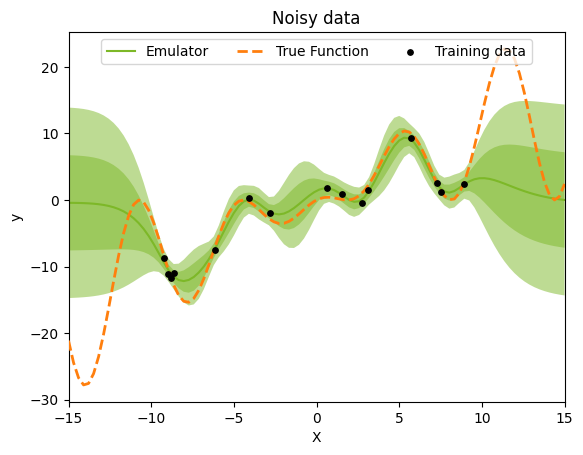

In [11]:
# Train a single-task emulator
emulator = tl.Emulator(id="emulator_single_task")
estimator_params = tl.EstimatorParams(
    estimator_type="single_task_gp"
)  # Set the estimator_type to single_task_gp
train_params = tl.TrainParams(estimator_params=estimator_params)
emulator.train(noisy_dataset, inputs=["X"], outputs=["y"], params=train_params)

# Plot the predictions
plt = emulator.plot(x_axis="X", y_axis="y", x_lim=(-15, 15), color="#7DB828")
plt.plot(
    X,
    y,
    linewidth=2,
    label="True Function",
    color="tab:orange",
    linestyle="dashed",
    zorder=10,
)
plt.scatter(X_data, y_noisy, label="Training data", color="k", s=15, zorder=11)
plt.legend(ncol=3, loc="upper center").set_zorder(12)
plt.title("Noisy data")
plt.show()

As you can see on the plot above the when using data with any noise in it, the `single_task_gp` will outperform the `zero_noise_gp`. Hence, the `zero_noise_gp` should be utilised for those specific scenarios where you wish to fit the data precisely; for example, for simulations or mathematical models with no added noise.

### **4. Delete datasets and trained emulators**

You can delete your datasets and emulators to keep your twinLab cloud account storage tidy.

Please be aware that this is permanent. Always consider keeping your data locally backed up.

`Emulator.delete` and `Dataset.delete` delete the emulator and the dataset respectively.


In [12]:
# Delete emulators and datasets
# Loop over the emulators trained in this tutorial
for emulator_i in [
    "emulator_zero_noise",
    "emulator_with_noise",
    "emulator_single_task",
]:
    # Delete the emulator
    tl.Emulator(emulator_i).delete()
# Loop over the datasets uploaded in this tutorial
for dataset_i in ["zero_noise", "with_noise"]:
    # Delete the dataset
    tl.Dataset(dataset_i).delete()

In this tutorial, you have explored the use of `zero_noise_gp` emulators for modelling deterministic, noise-free data. While this approach is powerful for capturing exact relationships in clean datasets, it should be used for the correct type of data, as the absence of a noise model can lead to unrealistic uncertainty estimates. 

With `twinLab`, sparse and noise free data can be quickly and conveniently trained using a `zero_noise_gp` to produce highly accurate results. This functionality simplifies the design and training of emulators, enhancing user convenience and facilitating the deployment of models specifically tailored to noise-free data scenarios.